<a href="https://colab.research.google.com/github/AndreasHennings/Visual-Appearance-from-Audio/blob/main/VAFA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Visual Appearance from Audio**

>Universität Regensburg

>Institut für Medieninformatik

>Praxisseminar Sommersemester 2020

>Dozenten: Prof Wolff, Henze

>Abgabedatum: 30.09.2020

>Autor: Andreas Hennings

>Matr. Nr.: 1755557

>Email: Andreas.Hennings@ur.de

**Project mission**

The main objective of this project is to create a video of a speaking person from an audio file.

Secondary objectives are:


*   The project can be operated by users with average technical expertise
*   The project should deliver results within reasonable time

**Prerequesites**

* A Google Account and an accesible Google Drive are needed for the project to store uploaded and generated data.

* Since the projects calculations are run on external servers, there are almost no hardware requirements for the user.

* This project was developed and tested using the Brave browser and should therefore run on Google Chrome as well. Possible issues while using this application may derive from browser incompabilites or add-ons that prevent code-execution (e.g. NoScript) or adblockers.

* A source video must be uploaded to provide the algorithm with the necessary data. The video should meet the following prerequesites:
>* The video should be in .mp4 format (other formats may work). There is no prerequesite for the videos resolution, but high resolutions will increase the time the application needs to do its calculations.
>* Depending on the videos fps, it should be neither too long or to short. It is recommended that there should be several hundred or thousand single images for the algorithm to chose from, so - depending on the source videos fps - a couple of minutes of recording should do. The video should also not be too long, since that will also increase the time the application needs.
>*The video should be cropped to the speakers face. There should be a neutral background without moving objects, and the speaker should try to avoid head movements.
* An audio track containing the sound for the video to be produced must be uploaded. For best results, this audio file should be recorded using the same microphone that was used for recording the source video file.


**Methodology**

This project is based on the hypothesis that the sound produced by a speaking person correlates to his/her facial expressions, especially lip movement. This hypothesis is in turn based on the observation that e.g. people with hearing-impairment can infer the sound a speaking person produces by observing their mouth ("lip-reading").





To achieve the desired results, this project combines a number of data-processing technologies. In short:

* First, this application extracts audio data from a source video file, calculates the distinct vocal features and correlates this data to the corresponding images extracted from the source video using a mean-shift algorithm for hierarchical clustering of multi-dimensional data.

* Next, the application extracts those features from a new audio file and determines which of the stored images of the source video correlate to those features. From this list of images, a image-similarity algorithm then chooses a single image that fits best.

* Finally, all images are combined into a video file and the new Audio is added.

Note: While implementing this projects, some code was written that is not necessary for the application to work, but shows intermediary results or visualizes data structures. I deliberately chose to not delete these cells, since they can help to better understand the methodology, find possible issues or tweak parameters for best results. These cells are marked as '(Optional)' and do not have to be executed.






# Data Preprocessing

**Mount drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Get Source videos framerate**

This is necessary to determine in how many packets the audio data needs to be split

In [ ]:
#Get Framerate as expression
frameRate = !ffprobe -v error -select_streams v:0 -show_entries stream=avg_frame_rate -of default=noprint_wrappers=1:nokey=1 "/content/gdrive/My Drive/Visual Appearance from Audio/ExampleProject/V2_src_c.m4v"

#Calculate and round Framerate
fps = round(float(eval(str(frameRate[0]))),2)

print("Your framerate is "+str(fps)+ " fps")

Your framerate is 24.01 fps


**Extract Audio from Source Video and save it on Google Drive**

Note: if the audio file already exists, you are asked to confirm overwriting it at the bottom of the cell below

In [ ]:
!ffmpeg -i "/content/gdrive/My Drive/Visual Appearance from Audio/ExampleProject/V2_src_c.m4v" -vn "/content/gdrive/My Drive/Visual Appearance from Audio/ExampleProject/V2_audio.mp3"

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

**Open Audio for MFCC calculation**


In [ ]:
import matplotlib.pyplot as plt
import librosa, librosa.display
import numpy as np

srcAudio = "/content/gdrive/My Drive/Visual Appearance from Audio/ExampleProject/V2_audio.mp3"
newAudio = "/content/gdrive/My Drive/Visual Appearance from Audio/ExampleProject/V2_audio_new.mp3"



srcSignal, sr = librosa.load(srcAudio, sr=22050) # sr = samplerate
newSignal, sr = librosa.load(newAudio, sr=22050)

# n_fft is the number of samples to be used for calculation
# hop_length is the number of samples each step is apart

n_fft = round(22050/fps)
hop_length = n_fft

print (n_fft)
print (hop_length)


918
918


**(Optional) Display audio features**

Waveform


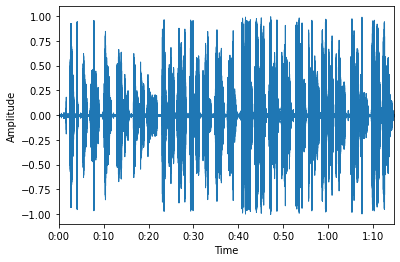

Powerspectrum


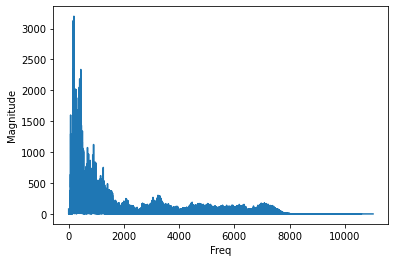

Spectrogram


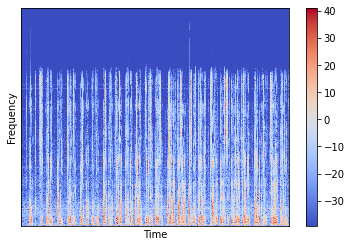

In [ ]:
# Show waveform
print("Waveform")
librosa.display.waveplot(srcSignal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

# Show power spectrum using Fourier Transformation
print("Powerspectrum")
fft = np.fft.fft(srcSignal)
mag = np.abs(fft)
freq = np.linspace(0, sr, len(mag))
l_freq = freq[:int(len(freq)/2)]
l_mag = mag[:int(len(mag)/2)]
#show graph
plt.plot(l_freq, l_mag)
plt.xlabel("Freq")
plt.ylabel("Magnitude")
plt.show()

#Show spectrogram
print("Spectrogram")
stft = librosa.core.stft(srcSignal, hop_length=hop_length, n_fft=n_fft)
spec = np.abs(stft)
log_spec = librosa.amplitude_to_db(spec)
librosa.display.specshow(log_spec, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()


**Calculate MFCCs**

The raw audio data stored in the file is not suitable for determining which sound has been produced by the speaker, so we need to calculate the Mel-frequency cepstral coefficients (MFCCs).


n_mfcc is the number of MFCCs to be calculated for each frame and can be tweaked to improve results.

Since the results are in a list ordered by MFCCs, the resulting matrix m needs to be transposed to create a list ordered by framesnumbers.


In [ ]:
srcMFCCs = librosa.feature.mfcc(srcSignal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
srcM = srcMFCCs.transpose()
print(len(srcM))

newMFCCs = librosa.feature.mfcc(newSignal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
newM = newMFCCs.transpose()
print(len(newM))

m = np.concatenate((srcM,newM))
print (len(m))

1794
532
2326


**(Optional) Show MFCC spectrogram and array dimensions**



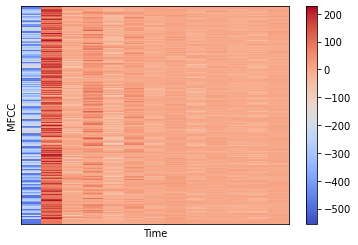

2324
13


In [ ]:
#show spectrogram

librosa.display.specshow(m, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

print (len(m))
print (len(m[0]))

**Importing video and converting to image sequence**

We import the video and store the images. Also, we convert the images to greyscale and store it in an other array.

In [ ]:
import cv2
from skimage.transform import resize

images=[]
gImages=[]

vidcap = cv2.VideoCapture("/content/gdrive/My Drive/Visual Appearance from Audio/ExampleProject/V2c.m4v")
success,image = vidcap.read()
count = 0
while success:
  success,image = vidcap.read()
  print('Reading frame: ', count)
  count += 1
  images.append(image)
  try:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    g = resize(gray,(256,256))
    gImages.append(g)
  except: #If we cant create a bw-image, erase src-image from stack
    images.pop()
    print("something went wrong")

  
 
  
print (len(images))


Reading frame:  0
Reading frame:  1
Reading frame:  2
Reading frame:  3
Reading frame:  4
Reading frame:  5
Reading frame:  6
Reading frame:  7
Reading frame:  8
Reading frame:  9
Reading frame:  10
Reading frame:  11
Reading frame:  12
Reading frame:  13
Reading frame:  14
Reading frame:  15
Reading frame:  16
Reading frame:  17
Reading frame:  18
Reading frame:  19
Reading frame:  20
Reading frame:  21
Reading frame:  22
Reading frame:  23
Reading frame:  24
Reading frame:  25
Reading frame:  26
Reading frame:  27
Reading frame:  28
Reading frame:  29
Reading frame:  30
Reading frame:  31
Reading frame:  32
Reading frame:  33
Reading frame:  34
Reading frame:  35
Reading frame:  36
Reading frame:  37
Reading frame:  38
Reading frame:  39
Reading frame:  40
Reading frame:  41
Reading frame:  42
Reading frame:  43
Reading frame:  44
Reading frame:  45
Reading frame:  46
Reading frame:  47
Reading frame:  48
Reading frame:  49
Reading frame:  50
Reading frame:  51
Reading frame:  52
Rea

In [ ]:
print (images[0].shape)

(720, 614, 3)


# Video Synthesis

With the MFCCs calculated from audio data, we can now implement different solutions for video syntheses 

**Solution 1: Calculating the Euclidian Distance**

The MFCCs represents n Data Points in a k-Dimensional Space, where 
* n = number of frames 
* k = number of MFCCs

Understanding MFCCs as vectors, for each MFCC in our new Audio we can find the closest (= most similar) MFCC in our source audio.

Then, we can select the corresponding image and add it to the video.

In [ ]:

height, width, layers = images[0].shape
size = (width,height)
video = cv2.VideoWriter('/content/gdrive/My Drive/Visual Appearance from Audio/ExampleProject/result_euclidian.mp4',cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

for n in range(len(newM)):  
  nm = newM[n]
  minDist = 1000.0

  for s in range(len(srcM)):
    sm = srcM[s]
    dist = np.linalg.norm(nm-sm)
    
    if (dist < minDist):
      minDist = dist
      numImg = s

  imgList.append(images[numImg])  
  video.write(images[numImg])

video.release()
  


**Solution 2: Flat clustering using K-Means**

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 64
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(m)

clusters = kmeans.predict(m)
srcClusters = clusters[:len(srcM)]
newClusters = clusters[len(srcM):]

for c in srcClusters:
  print (c)

**Create a look-up-table** 

We need to create a list, where for each cluster ID all coresponding framenumbers are stored.


In [ ]:

labels_unique = np.unique(srcClusters)
n_clusters_ = len(labels_unique)

print("Number of unique labels: ",n_clusters_)
print()

lut=[] #creating the look-up table

for n in range(n_clusters): #0-64
  arr = np.where (srcClusters==n)
  arr = list(arr[0])
  
  lut.append(arr)  
  print("Cluster ID: %d in frames:" %n)
  print(arr)
  




**Calculate Image Similarity**

Since we have a list of frames for each cluster, we can determine the best image to append to our result video. To avoid flickering, we choose the most similar image.

Depending on the number of frames to choose from, this may take several seconds for each frame. 

I therefore added a threshold that can optionally by used to shorten calculation time. The value of 0.95 was empirically determined.

In [ ]:
from skimage.measure import compare_ssim
import imutils


def ImageSimilarity(img, imgs):
  threshold = 0.95
  resultImgNr = 0
  maxSim = 0.0

  
  for i in imgs:

    if i != img:
      (score, diff) = compare_ssim(gImages[img], gImages[i], full=True)
      diff = (diff * 255).astype("uint8")

      #if score>threshold:
        #return i
      
      if score > maxSim:
        maxSim = score
        resultImgNr = i
  
  print ("resultImgNr: ", resultImgNr)
  return resultImgNr
  

**Image Selection**

In [ ]:
img0 = 0
counter = 0
resultImages=[]

for nc in newClusters:

  
  while (len(lut[nc])==0):
    nc -= 1
  print("counter: ",counter," of ", len(newClusters),"clusterNr: ",nc,"Nr of entries:",len(lut[nc]), "Images", lut[nc])
 
  img1 = ImageSimilarity(img0,lut[nc])  
  resultImages.append(img1)  
    
      
  counter +=1
  img0 = img1
#print (resultImages)



counter:  0  of  466 clusterNr:  3 Nr of entries: 4 Images [216, 710, 755, 928]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  


resultImgNr:  216
counter:  1  of  466 clusterNr:  3 Nr of entries: 4 Images [216, 710, 755, 928]
resultImgNr:  710
counter:  2  of  466 clusterNr:  3 Nr of entries: 4 Images [216, 710, 755, 928]
resultImgNr:  928
counter:  3  of  466 clusterNr:  3 Nr of entries: 4 Images [216, 710, 755, 928]
resultImgNr:  710
counter:  4  of  466 clusterNr:  3 Nr of entries: 4 Images [216, 710, 755, 928]
resultImgNr:  928
counter:  5  of  466 clusterNr:  3 Nr of entries: 4 Images [216, 710, 755, 928]
resultImgNr:  710
counter:  6  of  466 clusterNr:  3 Nr of entries: 4 Images [216, 710, 755, 928]
resultImgNr:  928
counter:  7  of  466 clusterNr:  3 Nr of entries: 4 Images [216, 710, 755, 928]
resultImgNr:  710
counter:  8  of  466 clusterNr:  3 Nr of entries: 4 Images [216, 710, 755, 928]
resultImgNr:  928
counter:  9  of  466 clusterNr:  3 Nr of entries: 4 Images [216, 710, 755, 928]
resultImgNr:  710
counter:  10  of  466 clusterNr:  51 Nr of entries: 9 Images [249, 250, 289, 408, 767, 784, 977, 978

**Video Synthesis**

In [ ]:
height, width, layers = images[0].shape
size = (width,height)
video = cv2.VideoWriter('/content/gdrive/My Drive/Visual Appearance from Audio/ExampleProject/result_v2_meanshift100.mp4',cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

for n in range(0,len(resultImages),4):
  nr = resultImages[n]
  video.write(images[nr])
  video.write(images[nr+1])
  video.write(images[nr+2])
  try:
    nn = resultImages[n+1]
  except:
    nn = nr
  a=images[nr+2]
  b=images[nn]
  
  inter = cv2.addWeighted(a, 0.5, b, 0.5, 0)

  video.write(inter)
  
video.release()

**Add Sound to Video**

In [ ]:
!ffmpeg -i '/content/gdrive/My Drive/Visual Appearance from Audio/ExampleProject/result_v2_meanshift100.mp4' -i "/content/gdrive/My Drive/Visual Appearance from Audio/ExampleProject/V2_audio_new.mp3" -map 0:v -map 1:a -c:v copy -shortest '/content/gdrive/My Drive/Visual Appearance from Audio/ExampleProject/result_v2_meanshift100_audio.mp4'

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

**(Optional) Interpolate Images**

In [ ]:
!ffmpeg -i '/content/gdrive/My Drive/Visual Appearance from Audio/ExampleProject/result_v2_meanshift100_audio.mp4' -filter:v minterpolate -r 120 '/content/gdrive/My Drive/Visual Appearance from Audio/ExampleProject/result_v2_meanshift100_audio_inter.mp4'

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

**Solution 3: Hierachical Clustering using MeanShift**

The MFCCs represents n Data Points in a k-Dimensional Space, where 
* n = number of frames 
* k = number of MFCCs

To determine the individually distinctable sounds these data points represent, we need to find clusters of neighboring data points.

We're using the MeanShift algorithm to determine where our datapoints cluster and calculate to which cluster our MFCCs correlate.

The parameter 'quantile' determines the number of clusters that are calculated and can be tweaked to improve results. The smaller the value, the more clusters are detected. 



In [ ]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(m, quantile=0.01, n_samples=3000)

# Calculate Clusters
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(m)

allClusters = ms.labels_

srcClusters = allClusters[:len(srcM)]
newClusters = allClusters[len(srcM):]


mlabels_unique = np.unique(allClusters)
mn_clusters_ = len(mlabels_unique)

print("Nr of Clusters:", mn_clusters_," src:",len(srcClusters)," new:",len(newClusters))


Nr of Clusters: 81  src: 1794  new: 532


**Create Look-up-table**

In [ ]:
lut=[]
for n in range(mn_clusters_): #0-64
  arr = np.where (srcClusters==n)
  arr = list(arr[0])
  a = arr[:100]

  lut.append(a)  
  print("Cluster ID: %d in frames:" %n," len: ",len(a))
  print(a)

Cluster ID: 0 in frames:  len:  100
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 119, 120, 121, 122, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 214, 215, 216, 217]
Cluster ID: 1 in frames:  len:  97
[78, 79, 192, 193, 201, 211, 212, 213, 243, 270, 271, 280, 327, 328, 344, 346, 358, 370, 371, 424, 425, 426, 428, 445, 455, 456, 471, 472, 473, 491, 492, 495, 509, 525, 578, 579, 607, 616, 634, 660, 724, 728, 741, 751, 752, 812, 813, 814, 849, 883, 884, 946, 947, 949, 950, 1032, 1033, 1051, 1091, 1105, 1106, 1123, 1150, 1151, 1176, 1177, 1241, 1242, 1319, 1391, 1392, 1433, 1434, 1467, 1495, 1496, 1508, 1511, 1517, 1520, 1531, 1532, 1586, 1587, 1592, 1601, 1610, 1635, 1644, 1651, 1721, 1776, 17

**Calculating Video from Selected Frames**

In [ ]:
img0 = 0
counter = 0
resultImages=[]

for nc in newClusters:

  
  while (len(lut[nc])==0):
    nc -= 1
  print("counter: ",counter," of ", len(newClusters),"clusterNr: ",nc,"Nr of entries:",len(lut[nc]), "Images", lut[nc])
  print()
  img1 = ImageSimilarity(img0,lut[nc])  
  print ("Result:", img1)
  resultImages.append(img1)  
    
      
  counter +=1
  img0 = img1
 



counter:  0  of  532 clusterNr:  7 Nr of entries: 73 Images [30, 114, 258, 259, 279, 339, 343, 434, 474, 483, 484, 494, 510, 518, 596, 602, 623, 624, 625, 626, 627, 628, 681, 698, 743, 808, 833, 966, 974, 975, 1010, 1037, 1039, 1040, 1041, 1042, 1109, 1112, 1114, 1115, 1116, 1127, 1228, 1238, 1254, 1257, 1258, 1259, 1260, 1309, 1321, 1350, 1360, 1372, 1398, 1407, 1437, 1439, 1472, 1474, 1512, 1516, 1534, 1549, 1604, 1618, 1627, 1636, 1645, 1650, 1725, 1756, 1778]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  


resultImgNr:  30
Result: 30
counter:  1  of  532 clusterNr:  7 Nr of entries: 73 Images [30, 114, 258, 259, 279, 339, 343, 434, 474, 483, 484, 494, 510, 518, 596, 602, 623, 624, 625, 626, 627, 628, 681, 698, 743, 808, 833, 966, 974, 975, 1010, 1037, 1039, 1040, 1041, 1042, 1109, 1112, 1114, 1115, 1116, 1127, 1228, 1238, 1254, 1257, 1258, 1259, 1260, 1309, 1321, 1350, 1360, 1372, 1398, 1407, 1437, 1439, 1472, 1474, 1512, 1516, 1534, 1549, 1604, 1618, 1627, 1636, 1645, 1650, 1725, 1756, 1778]

resultImgNr:  114
Result: 114
counter:  2  of  532 clusterNr:  0 Nr of entries: 100 Images [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 119, 120, 121, 122, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 2

# Results

Lore ipsum